Q: What is the estimate kband background?

In [1]:
import numpy as np
%matplotlib inline
from pylab import *

import scipy.integrate
import scipy




from collections import namedtuple

import numpy as np
%matplotlib inline
from pylab import *

import astropy
from astropy import units as ur
from astropy import constants as cc
import astropy.modeling.blackbody



In [2]:
hc = cc.h * cc.c
micron = ur.meter * 1e-6
K = ur.Kelvin



In [3]:


lam = np.arange(2000, 2500) * ur.nanometer
epp = hc/lam
Temp = 299 * K
L_e_Omega_lam = astropy.modeling.blackbody.blackbody_lambda(lam, Temp)

number_mirrors = 3

emissivity = 1 - 0.97**(2)

In [4]:
L_e_Omega_lam.unit

Unit("erg / (Angstrom cm2 s sr)")

In [5]:
Amirror = 30 * ur.meter**2 
Omega_1as2 = 1/4.25e10 * ur.steradian

Phi_lam = L_e_Omega_lam * Amirror * Omega_1as2 * emissivity

In [6]:
Phi_lam.to(ur.Watt/ur.angstrom)
N_lam = Phi_lam/epp

In [7]:
def angle_to_omega(rad):
    
    return np.pi*np.sin(rad)**2

In [8]:
def fnum_to_Omega(fnum):
    " See eq. 24 https://www.labsphere.com/site/assets/files/2551/integrating_sphere_theory_apps_tech_guide.pdf"
    
    return np.pi/(4*fnum*fnum) * ur.steradian

In [9]:
def model(lam, number_mirrors=3, temp=299*K, D_tel=10*ur.meter, fnum=2, reflectivity=0.96,
         efficiency = .3):
    """ Return BB curve for the reflective component of a telescope system
    
    Args:
        lam[] -- Wavelengths [L] to consider
        number_mirrors -- Number of warm reflections in the system
        temp -- The warm temperature [Temp]
        D_tel -- Telescope diaemter [L]
        fnum -- The focal ratio of the camera
        reflectivity -- Reflectivity of the bounce
        efficiency -- System efficiency
        
    Returns:
        Spectrum in units of 1/(s Angstrom) with same dimensionality as lam
     """
    epp = hc/lam

    # Specific spectral radiance in photon / sr/ m2 / bw
    L_e_Omega_lam = astropy.modeling.blackbody.blackbody_lambda(lam, temp)
    emissivity = 1 - reflectivity**(number_mirrors)
    print("Emissivity of system is: %3.2f " % emissivity)
        
    Omega = fnum_to_Omega(fnum)
    # DOESNT WORK BECAUSE OF flam BELOW A_pixel = (18*ur.micron)**2   
    A_1as = (D_tel*fnum/206265)**2
    
    AREA = A_1as

    Phi_lam = L_e_Omega_lam * Omega * AREA * emissivity # Phi_lam is [Power]/[Bandwidth]
    N_lam = Phi_lam/epp # N_lam is [Hz]/[Bandwidth]
    
    nlam = N_lam.to(ur.Hertz/ur.angstrom) / (ur.Hertz/ur.angstrom) * efficiency
    flam = L_e_Omega_lam * (1*ur.arcsecond)**2 * emissivity * efficiency

    return nlam, flam.to(ur.erg/ur.second/ur.Angstrom/ur.cm**2)

## Sanity checks

In [10]:
print("This is a radiometry sanity check, both values should be the same")



Dtel = 6.5*ur.meter
fnum = 2
eps = .12 * .3


# Detector based
Omega_fnum = fnum_to_Omega(fnum)
A_1as = (Dtel*fnum/206265)**2


# Telescope based
Omega_1as = (ur.arcsecond)**2
Atel = np.pi*(Dtel/2)**2

v = astropy.modeling.blackbody.blackbody_lambda(24000, 300) * \
    Omega_fnum * eps * A_1as

print("Detector based: ", v.to(ur.erg/ur.s/ur.Angstrom))

v = astropy.modeling.blackbody.blackbody_lambda(24000, 300) * \
     Omega_1as * eps * Atel

print("Telescope based: ", v.to(ur.erg/ur.s/ur.Angstrom))




This is a radiometry sanity check, both values should be the same
Detector based:  8.804900068224497e-11 erg / (Angstrom s)
Telescope based:  8.80491660983222e-11 erg / (Angstrom s)


Compare to SpectralCalc.com

 Spectral Radiance: 	0.0031363 W/m2/sr/µm
  @ 2.4 µm and 300 K with emissivity of 1

In [11]:
astropy.modeling.blackbody.blackbody_lambda(24000, 300).to(ur.Watt/ur.meter**2/ur.steradian/ur.micron)

<Quantity 0.00313586 W / (m2 micron sr)>

## Calculations

Emissivity of system is: 0.12 
Emissivity of system is: 0.08 
Emissivity of system is: 0.12 
Emissivity of system is: 0.12 


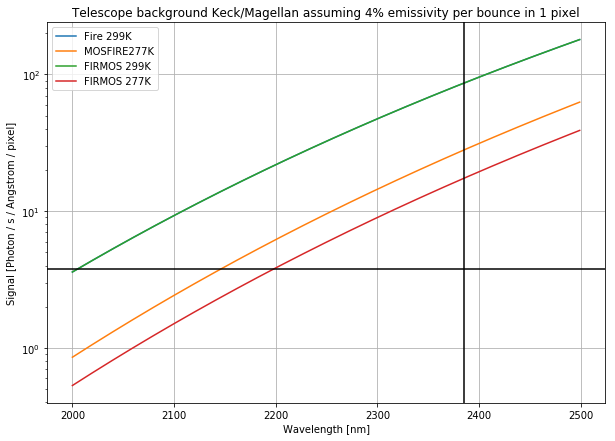

In [12]:

m = ur.meter
lam = np.arange(2000, 2500) * ur.nm

figure(figsize=(10,7))
semilogy(lam, model(lam, number_mirrors=3, fnum=3.54, D_tel=6.5*m, temp=299*K)[0])
semilogy(lam, model(lam, number_mirrors=2, fnum=1.8, D_tel=10*m, temp=277*K)[0])

semilogy(lam, model(lam, number_mirrors=3, fnum=1.6, D_tel=6.5*m, temp=299*K)[0])
semilogy(lam, model(lam, number_mirrors=3, fnum=1.6, D_tel=6.5*m, temp=277*K)[0])


legend(["Fire 299K", "MOSFIRE277K", "FIRMOS 299K", "FIRMOS 277K"])
xlabel("Wavelength [nm]")
ylabel("Signal [Photon / s / Angstrom / pixel]")
title("Telescope background Keck/Magellan assuming 4% emissivity per bounce in 1 pixel")
grid(True)


# The crosshair comes from GWEN, see info at end of this file
axhline(3.8, color='black')
axvline(2385, color='black')

In [13]:
_,flam = model(lam, number_mirrors=3, fnum=3.54, D_tel=6.5*m, temp=299*K)


(flam*lam**2/cc.c).to(ur.Jansky)

Emissivity of system is: 0.12 


<Quantity [0.00014353, 0.00014505, 0.00014658, 0.00014813, 0.00014969,
           0.00015126, 0.00015286, 0.00015446, 0.00015609, 0.00015772,
           0.00015938, 0.00016104, 0.00016273, 0.00016443, 0.00016614,
           0.00016787, 0.00016962, 0.00017139, 0.00017317, 0.00017496,
           0.00017678, 0.00017861, 0.00018046, 0.00018232, 0.0001842 ,
           0.0001861 , 0.00018802, 0.00018995, 0.00019191, 0.00019388,
           0.00019586, 0.00019787, 0.0001999 , 0.00020194, 0.000204  ,
           0.00020608, 0.00020818, 0.0002103 , 0.00021244, 0.0002146 ,
           0.00021678, 0.00021898, 0.00022119, 0.00022343, 0.00022569,
           0.00022797, 0.00023027, 0.00023259, 0.00023493, 0.00023729,
           0.00023967, 0.00024208, 0.0002445 , 0.00024695, 0.00024942,
           0.00025191, 0.00025442, 0.00025696, 0.00025952, 0.0002621 ,
           0.00026471, 0.00026733, 0.00026998, 0.00027266, 0.00027536,
           0.00027808, 0.00028082, 0.0002836 , 0.00028639, 0.00028921,
      

### MOSFIRE Comparison

To compare to MOSFIRE I took the data from the Keck Webpage (1) below and Gwen sent me Chuck's raw background measurements (2).

## From Keck web page

(19, 13)

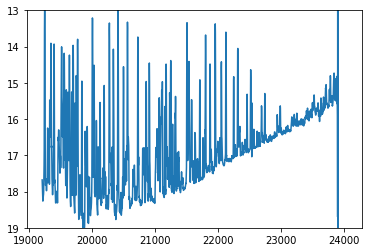

In [14]:
#https://www2.keck.hawaii.edu/inst/mosfire/sky_lines.html
mosfire = astropy.io.fits.open("Ksky_abmag.fits")

l0 = mosfire[0].header["CRVAL1"]
dl = mosfire[0].header["CDELT1"]

webms = mosfire[0].data
webll = np.arange(len(webms))
webll = webll*dl + l0

plot(webll,webms)
ylim(19,13)

## Data from Chuck

MosfireSkySpec_for_nick.tar (email from Gwen who got it from Chuck)

/Users/npk/Dropbox/virtualenv/astropy/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/npk/Dropbox/virtualenv/astropy/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(19, 13)

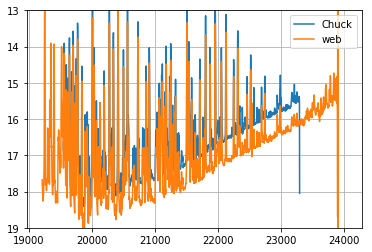

In [15]:
chuckmos = astropy.io.fits.open("MosfireSkySpec/Ksky_cal_pA.fits")

l0 = chuckmos[0].header["CRVAL1"]
dl = chuckmos[0].header["CDELT1"]

ms = chuckmos[0].data
ll = np.arange(len(ms))
ll = ll*dl + l0

mosll = ll * ur.Angstrom

# for a single spatial row for the 0.7" entrance slit. -- I.e. 0.7" x 0.18"
ms = ms * ur.erg/ur.second/ur.cm**2/ur.Angstrom/(0.7 * ur.arcsecond * 0.18 * ur.arcsecond) * ur.arcsecond**2
mjy = (ms * mosll**2/cc.c).to(ur.Jansky)


zpt = 3631*ur.Jansky
mosmag = -2.5 * np.log10(mjy/zpt)

plot(mosll, mosmag)
plot(webll,webms)


legend(["Chuck", "web"])
grid(True)
ylim(19,13)

### Data from Gemini

In [16]:

gdat = np.loadtxt("Gemini/mk_skybg_zm_16_10_ph.dat").T

gl = gdat[0] * ur.nm
gs = gdat[1] / ur.second / ur.nm / ur.meter**2

In [17]:
gepp = hc/gl
gfl = (gepp * gs).to(ur.erg/ur.second/ur.Angstrom/ur.cm**2)

gjy = (gfl * gl**2/cc.c).to(ur.Jansky)


zpt = 3631*ur.Jansky
gemmag = -2.5 * np.log10(gjy/zpt)


## Transmissivity from SpectralCalc

In [18]:
from astropy.convolution import convolve, Box1DKernel

In [19]:
mkspecc = np.loadtxt("spectralcal/nickkonidaris779541946_microns.txt")
lcospec = np.loadtxt("spectralcal/nickkonidaris177673445_microns.txt")
mkspecc = mkspecc[::10]
lcospec = lcospec[::10]

In [23]:

def get_spec(specc, temp=288):
    scl, sct = specc.T

    scl = scl * ur.micron

    scbb = astropy.modeling.blackbody.blackbody_lambda(scl, temp) * ur.arcsecond**2

    scflam = (1-sct) * scbb 
    scfnu = (scflam*scl**2/cc.c).to(ur.Jansky)
    zpt = 3631*ur.Jansky

    scfnuprime = convolve(scfnu, Box1DKernel(11000))
    scmag = -2.5 * np.log10(scfnuprime/3631)
    
    return scl, scmag


mklam, mkmag = get_spec(mkspecc)
lcolam, lcomag = get_spec(lcospec)


# Now compute and Plot things up

Emissivity of system is: 0.39 
 
-0.0095 x + 37.37
2.100031079715778 micron 19.69508037286538
Emissivity of system is: 0.39 
 
-0.009348 x + 36.69
2.100031079715778 micron 19.69508037286538
Emissivity of system is: 0.28 
 
-0.009941 x + 39.71
2.100031038784423 micron 20.528152914261447


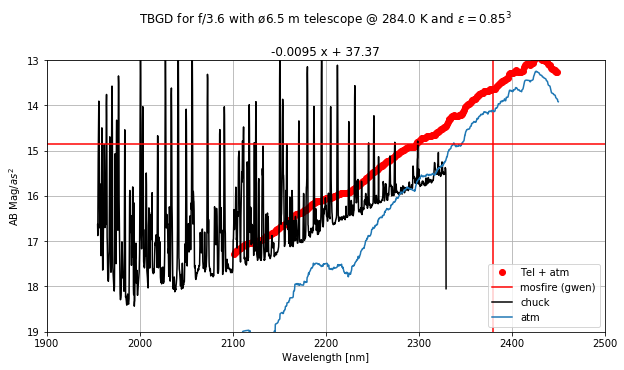

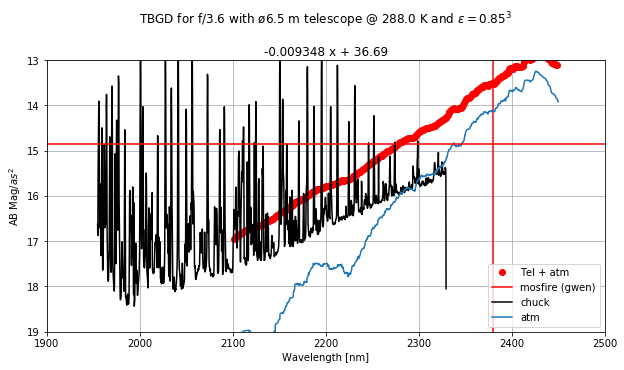

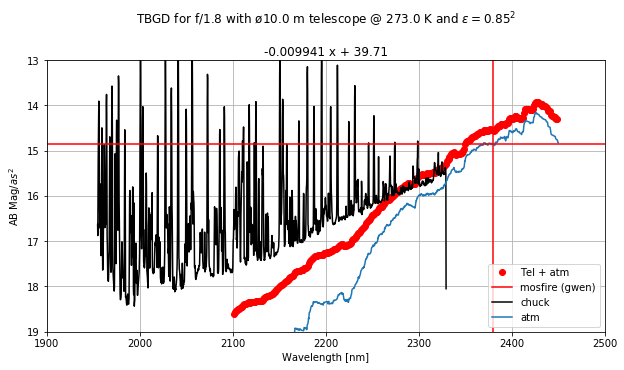

In [82]:
def plot_telescope(num_mirror=3, fnum=3.6, dtel=6.5*m, temp=300*K, reflectivity=0.9, atm_spec=None):
    lam = np.arange(2000, 2500) * ur.nm

    _, flam = model(lam, number_mirrors=num_mirror, fnum=fnum, D_tel=dtel, temp=temp, reflectivity=reflectivity)
    flam = flam 
    fjy = (flam * lam**2/cc.c)

    zpt = 3631*ur.Jansky
    mag = -2.5 * np.log10(fjy/zpt)
    ff = np.poly1d(np.polyfit(lam, mag, 1))
    print(ff)

    if atm_spec is not None:
        sl, sm = atm_spec

        sf = 10**(-sm/2.5)
        
        fun = scipy.interpolate.interp1d(sl.to(ur.nm), sf, bounds_error=False)
        atm = fun(lam.to(ur.nm))

        mag = -2.5*np.log10(atm + fjy/zpt)


    title("TBGD for f/%2.1f with ø%s telescope @ %s and $\epsilon=%s^{%s}$\n%s" % (fnum, dtel, temp, 
                                                                               reflectivity, num_mirror,ff))
    plot(lam, mag, 'ro')


    xlabel("Wavelength [nm]")
    ylabel("AB Mag/$as^2$")

    gwens_data = (2380.1, 2.745e-17 * ur.erg/ur.s/ur.cm**2/ur.angstrom * (2380.1*ur.nm)**2/cc.c)
    h = -2.5 * np.log10(gwens_data[1]/zpt/(0.7*0.18))

    axvline(gwens_data[0], color='red')
        

    plot(mosll/10, mosmag, 'k')
    ylim(19,13)
    xlim(1900, 2500)
    
    if atm_spec is None:
        legend(["Tel + atm", 'mosfire (gwen)', 'chuck'])
    else:
        sl, sm = atm_spec
        plot(sl.to(ur.nm), sm)
        
        print(sl[10], sm[10])
        legend(["Tel + atm", 'mosfire (gwen)', 'chuck', "atm"])
        
    axhline(h, color='red')

    grid(True)



em = .85
figure(figsize=(10,5))
plot_telescope(3, 3.6, 6.5*m, 284*K, em, atm_spec=(lcolam, lcomag))

figure(figsize=(10,5))
plot_telescope(3, 3.6, 6.5*m, 288*K, em, atm_spec=(lcolam, lcomag))

figure(figsize=(10,5))
plot_telescope(2, 1.8, 10*m, 273*K, em, atm_spec=(mklam, mkmag))


From GWEN Mosfire background in K
23847.099  3.01282e-17 ergs/s/cm^2/A with a 0.7" slit

8.34641103 × 10-13 erg

In [ ]:
epp=hc/(23847*ur.Angstrom)
epp.to(ur.erg)

In [ ]:

Sig = 3.01e-17

epp = 8.33e-13 # erg
Atel = 760000 # cm2

pixels = 2.7

Sig/epp*Atel/pixels**2 # Photon/s/Angstrom